In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import numpy as np
import numba
import pickle
import seaborn as sns
sns.set(
    style='ticks',
    font_scale=1.5
)
from rakott.mpl import fig_panel_labels
import string

# Modifier model

| pheno-genotype     | mA  | mB     | MA  | MB     |
|------|-----|--------|-----|--------|
| frequency    | $x_1$  | $x_2$ | $x_3$  | $x_4$ |
| fitness    | $\omega_A$ | $\omega_B$    | $\omega_A$ | $\omega_B$    |
| vertical transmission rate | $\rho$   | $\rho$      | $P$   | $P$      |


The population recurrence is 

$$
\bar{\omega} x_1' = x_1 \omega_A ((1-\rho)(x_1 + x_3)+\rho) + x_2 \omega_B(1-\rho)(x_1 + x_3) \\
\bar{\omega} x_2' = x_1 \omega_A (1-\rho)(x_2 + x_4) + x_2 \omega_B ((1-\rho)(x_2 + x_4) + \rho) \\
\bar{\omega} x_3' = x_3 \omega_A ((1-P)(x_1 + x_3) + P) + x_4 \omega_B (1-P)(x_1 + x_3) \\
\bar{\omega} x_4' = x_3 \omega_A (1-P)(x_2 + x_4) + x_4 \omega_B ((1-P)(x_2 + x_4) + P) \\
\bar{\omega} = \omega_A (x_1 + x_3) + \omega_B (x_2 + x_4)
$$

# Modifier numerical simulation

In [2]:
@numba.jit()
def recursion(x, wA, wB, ρ, P, N=0):
    x1, x2, x3, x4 = x
    x1_ = x1 * wA * ((1 - ρ) * (x1 + x3) + ρ) + x2 * wB * (1 - ρ) * (x1 + x3)
    x2_ = x1 * wA * (1 - ρ) * (x2 + x4) + x2 * wB * ((1 - ρ) * (x2 + x4) + ρ)
    x3_ = x3 * wA * ((1 - P) * (x1 + x3) + P) + x4 * wB * (1 - P) * (x1 + x3)
    x4_ = x3 * wA * (1 - P) * (x2 + x4) + x4 * wB * ((1 - P) * (x2 + x4) + P)
    x = x1_, x2_, x3_, x4_
    x = np.array(x)
    x /= x.sum()
    if N > 0:
        x = np.random.multinomial(N, x) / N
    return x

recursion((0.4,0.4,0.1,0.1), 1.1, 1, 0.1, 0, 1e6)

array([ 0.402136,  0.397247,  0.100312,  0.100305])

In [3]:
@numba.jit()
def evolution(ρ0=0.1, W = 1, w = 0.1, m0 = 0.999, A0 = 0.1, n = 10000000, N = 0, envch_rate=0):
    N = int(N)
    ρ = ρ0
    P = ρ/10
    W_, w_ = w, W
    x = np.zeros((4, n))
    x[:, 0] = [m0*A0, m0*(1-A0), (1-m0)*A0, (1-m0)*(1-A0)]
    wbar = np.empty(n, dtype=float)
    rate = np.empty(n, dtype=float)    
    invasions = []

    for t in range(n-1):
        if envch_rate == 0:
            W_, w_ = w_, W_
        elif np.random.random() < envch_rate:
            W_, w_ = W, w
        else:
            W_, w_ = w, W
        rate[t] = ρ * (x[0,t] + x[1,t]) + P * (x[2,t] + x[3,t])
        wbar[t] = (x[0,t] + x[2,t]) * W_ + (x[1,t] + x[3,t]) * w_
        x[:, t+1] = recursion(
            x[:, t], W_, w_, ρ, P, N
        )
        t = t+1
        if x[0,t] + x[1,t] > 0.999:
            if x[0,t] > x[1,t]:
                x[0,t] -= 0.0001
                x[2,t] += 0.0001
            else:
                x[1,t] -= 0.0001
                x[3,t] += 0.0001        
        if x[0,t] + x[1,t] < 0.0001:
            x[0,t], x[1,t], x[2,t], x[3,t] = x[2,t], x[3,t], x[0,t], x[1,t]
            print(P, end=' ')
            ρ, P = P, P/10        
            invasions.append(t)
    wbar[-1] = wbar[-2]
    rate[-1] = rate[-2]
    return x, invasions, rate, wbar

In [4]:
def plot_invasions(x, invasions, rate, wbar, ρ0, time_step=1, inset=None, 
                   panel_labels=string.ascii_uppercase, filename=None):
    fig, axes = plt.subplots(4, 1, figsize=(6, 14), sharey=False, sharex=True)
    axes[0].plot(
        np.arange(0, x.shape[1], time_step),
        x[0,::time_step] + x[2,::time_step], 
        label='A'
    )
#     axes[0].axhline(0.5, ls='--', color='k', alpha=0.8)
    t = 0
    for i, inv in enumerate(invasions):
        for j in range(4): axes[j].axvline(inv, ls='--', lw=1, color='gray')
        axes[1].plot(
            np.arange(t, inv, time_step),
            x[2,t:inv:time_step] + x[3,t:inv:time_step], 
            label='{:.2g}'.format(ρ0/(10**(i+1)))
        )
        t = inv
    axes[2].plot(
        np.arange(0, rate.shape[0], time_step),
        rate[::time_step]
    )
    axes[3].plot(
        np.arange(0, wbar.shape[0], time_step),
        wbar[::time_step]
    )
    
    # inset ################
    if inset is not None:
        axins = inset_axes(axes[3], width="50%", height="40%", loc=4)
        axins.plot(
            np.arange(inset, wbar.shape[0], time_step),
            wbar[inset::time_step]
        )
        axins.set(xscale='log', xlim=(inset, None), yscale='log', xticks=[], yticks=[])
        plt.xticks(visible=False)
        plt.yticks(visible=False)

        for i, inv in enumerate(invasions):
            axins.axvline(inv, ls='--', lw=1, color='gray')

        mark_inset(axes[3], axins, loc1=2, loc2=1)
    ########################
    
    axes[0].set(ylim=(0,1), ylabel='Frequency of phenotype $A$')
    axes[1].set(ylim=(0,1), ylabel='Invader frequency')
    axes[1].legend(title='Rate')
    axes[2].set(ylabel='Mean vertical transmission rate', yscale='log', ylim=(rate.min(), rate.max()))
    axes[3].set(ylabel=r'Mean fintess - $\bar{\omega}$', xlabel='Time', xscale='log')

    labels = fig_panel_labels(axes, panel_labels, xcoord=-0.12, ycoord=1.075)
    fig.tight_layout()
    if filename is not None:
        fig.savefig(filename, bbox_inches='tight', bbox_extra_artists=labels)
    return fig, axes

In [91]:
for w in [0.1, 0.5, 0.9]:
    x, invasions, rate, wbar = evolution(ρ0=0.1, n=1000000, w=w, envch_rate=0, N=0)
    np.savez_compressed('A1B1_modifier_invasions_w{:.1f}.npz'.format(w), x=x, invasions=invasions, rate=rate, wbar=wbar)

0.01 0.001 0.0001 1e-05 0.01 0.001 0.0001 0.01 0.001 

In [15]:
w = 0.1

d = np.load('A1B1_modifier_invasions_w{:.1f}.npz'.format(w))
x = d['x']
invasions = d['invasions']
rate = d['rate']
wbar = d['wbar']
del d

/Users/yoavram/miniconda3/envs/Milpitas/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


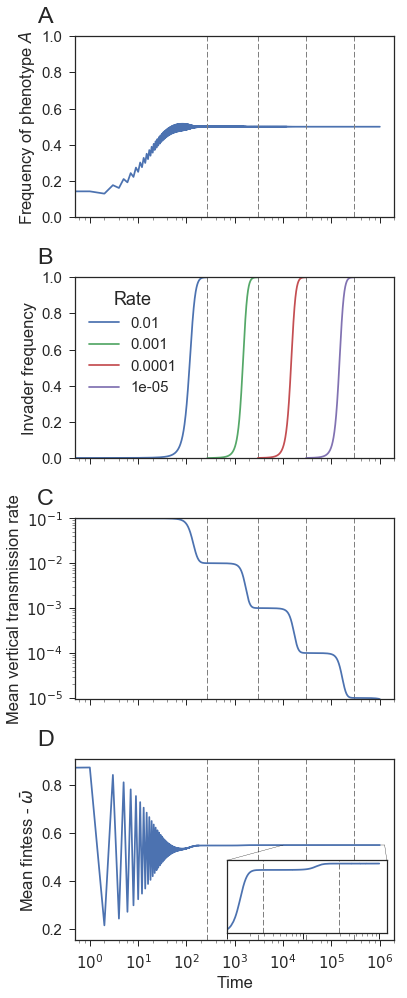

In [16]:
fig, axes = plot_invasions(x, invasions, rate, wbar, ρ0=0.1, inset=10000, panel_labels='ABCD',
        filename='../figures/A1B1_modifier_invasions_w{:.1f}.pdf'.format(w))

After creating several multi-panel figures, they can be merged with:
```sh
!pdfjam A1B1_modifier_invasions_w0.1.pdf  A1B1_modifier_invasions_w0.5.pdf A1B1_modifier_invasions_w0.9.pdf -o A1B1_modifier_invasions.pdf --landscape --nup 3x1
```

## Stochastic environment

In [8]:
x, invasions, rate, wbar = evolution(ρ0=0.45, n=100000000, envch_rate=0.5, N=0)

0.045 0.0045 0.00045 

In [9]:
np.savez_compressed('stoch_modifier_invasions.npz', x=x, invasions=invasions, rate=rate, wbar=wbar)

In [10]:
d = np.load('stoch_modifier_invasions.npz')
x = d['x']
invasions = d['invasions']
rate = d['rate']
wbar = d['wbar']
del d

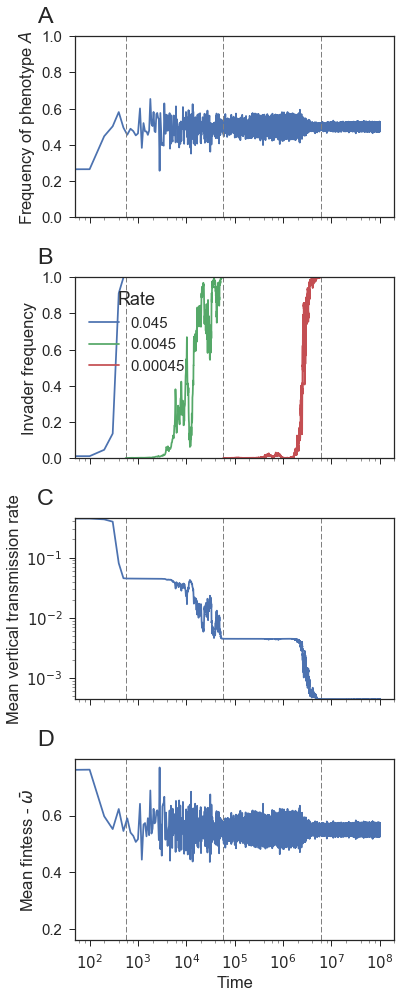

In [17]:
fig, axes = plot_invasions(x, invasions, rate, wbar, ρ0=0.45, time_step=100, inset=False, filename='../figures/stoch_modifier_invasions.pdf')